In [1]:
#import warnings
#warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import viz

import scipy
from scipy import stats
import sklearn.impute as simpleImputer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression 



import acquire
import prepare
import evaluate
import env

In [2]:
df,train,validate,test = prepare.prep_zillow()


# Load your zillow dataset.

# Fit a linear regression model (ordinary least squares) and compute yhat, predictions of taxvaluedollarcnt using only calculatedfinishedsqft.


In [3]:
#scale continous data

train_scaled = train.copy()

columns_to_scale = ["area","tax value"]
scaler = MinMaxScaler()
train_scaled[columns_to_scale] = scaler.fit_transform(train_scaled[columns_to_scale])

X_train,X_validate,X_test = train[["area"]],validate[["area"]],test[["area"]]
y_train,y_validate,y_test = train["tax value"],validate["tax value"],test["tax value"]

X_train_scaled = scaler.fit_transform(X_train) ##only use fit_transform for training, after that use transform (equations are created)
X_validate_scaled = scaler.transform(X_validate)

In [4]:
train_scaled.columns

Index(['bedrooms', 'bathrooms', 'area', 'tax value', 'year built',
       'taxes yearly', 'fips', 'decade built'],
      dtype='object')

In [5]:
train_scaled = train_scaled.drop(columns=['bedrooms', 'bathrooms', 'year built',
       'taxes yearly', 'fips', 'decade built'])


In [6]:
pred_col = "tax value"
single_var = "area"

train_scaled = train_scaled.sample(n=1000, random_state=123)

train_scaled['yhat_baseline'] = train_scaled[pred_col].mean()

reg = LinearRegression().fit(train_scaled[[single_var]], train_scaled[pred_col])
train_scaled["yhat"] = reg.predict(train_scaled[[single_var]])

Text(0.5, 1.0, 'scatter plot of train_scaled data with regession and base line')

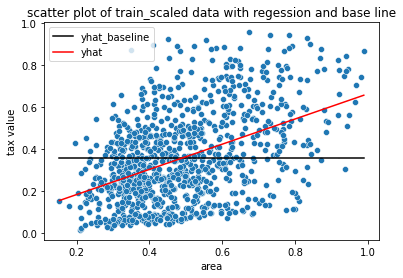

In [7]:
sns.scatterplot(data=train_scaled, x=single_var,y=pred_col)
sns.lineplot(data=train_scaled, x=single_var,y="yhat_baseline",color="black",label="yhat_baseline")
sns.lineplot(data=train_scaled, x=single_var,y="yhat",color="red",label="yhat")
plt.legend()
plt.title("scatter plot of train_scaled data with regession and base line")

In [8]:
train_scaled

,area,tax value,yhat_baseline,yhat
369012,0.649839,0.787327,0.355215,0.453427
1616669,0.569709,0.095253,0.355215,0.405262
1008997,0.374817,0.293215,0.355215,0.288112
361981,0.358967,0.222379,0.355215,0.278585
1737414,0.750514,0.595343,0.355215,0.513943
...,...,...,...,...
612825,0.729968,0.603162,0.355215,0.501593
1942014,0.253302,0.164616,0.355215,0.215070
163610,0.579395,0.491216,0.355215,0.411084
783877,0.458174,0.226452,0.355215,0.338218


# Plot the residuals for the linear regression model that you made.


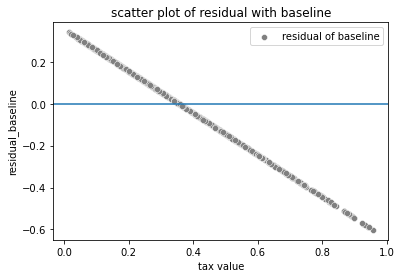

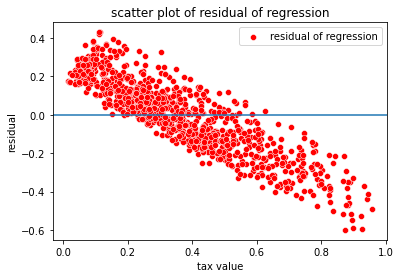

In [9]:
train_scaled["residual"] = train_scaled["yhat"] - train_scaled[pred_col]
train_scaled['residual_baseline'] = train_scaled['yhat_baseline'] - train_scaled[pred_col]

#sns.scatterplot(data=train_scaled, x=single_var,y=pred_col)
sns.scatterplot(data=train_scaled, x=pred_col,y="residual_baseline",color="grey",label="residual of baseline")
plt.axhline(y=0)
plt.legend()
plt.title("scatter plot of residual with baseline")
plt.show()

sns.scatterplot(data=train_scaled, x=pred_col,y="residual",color="red",label="residual of regression")
plt.axhline(y=0)
plt.legend()
plt.title("scatter plot of residual of regression")
plt.show()



# Calculate the sum of squared errors, explained sum of squares, total sum of squares, mean squared error, and root mean squared error for your model.


In [10]:
train_scaled['residual^2'] = train_scaled.residual ** 2
train_scaled['residual_baseline^2'] = train_scaled.residual_baseline ** 2

ESS = sum((train_scaled["yhat"] - train_scaled[pred_col].mean())**2)
print("ESS (explained sum of squares) = ", ESS)

SSE = sum(train_scaled['residual^2'])
print("SSE (sum of squared errors) = ", SSE)

MSE = SSE/len(train_scaled)
print("MSE (mean squared error) = ", MSE)

RMSE = (MSE)**.5
print("RMSE (root mean squared error) = ", RMSE)


ESS (explained sum of squares) =  9.414783070579343
SSE (sum of squared errors) =  35.817977559266666
MSE (mean squared error) =  0.03581797755926667
RMSE (root mean squared error) =  0.1892563804981662


# Calculate the sum of squared errors, mean squared error, and root mean squared error for the baseline model (i.e. a model that always predicts the average taxvaluedollarcnt amount).


In [11]:
ESS_baseline = sum((train_scaled["yhat_baseline"] - train_scaled[pred_col].mean())**2)
print("ESS baseline = ", ESS_baseline)

SSE_baseline = sum(train_scaled['residual_baseline^2'])
print("SSE baseline = ", SSE_baseline)

MSE_baseline = SSE_baseline/len(train_scaled)
print("MSE baseline = ", MSE_baseline)

RMSE_baseline = (MSE_baseline)**.5
print("RMSE baseline = ", RMSE_baseline)

ESS baseline =  0.0
SSE baseline =  45.23276062984599
MSE baseline =  0.04523276062984599
RMSE baseline =  0.21267994881945498


# Write python code that compares the sum of squared errors for your model against the sum of squared errors for the baseline model and outputs whether or not your model performs better than the baseline model.



In [12]:
if SSE < SSE_baseline:
    print("model performed better than baseline")
else:
    print("model performed worse than baseline")

model performed better than baseline


# What is the amount of variance explained in your model?


In [13]:
TSS = ESS + SSE ## TSS = TOTAL SUM OF SQUARES (EXPLAINED PLUS ERROR)
R2 = ESS/TSS ## RATIO
print(f"Percent of variance in tax value explained by area = ", round(R2*100,1), "%")

Percent of variance in tax value explained by area =  20.8 %


#Is your model better than the baseline model?


In [14]:
TSS_baseline = ESS_baseline + SSE_baseline ## TSS = TOTAL SUM OF SQUARES (EXPLAINED PLUS ERROR)
R2_baseline = ESS_baseline/TSS_baseline ## RATIO
print(f"Percent of baseline variance in tax value explained by area = ", round(R2_baseline*100,1), "%")

if R2 > R2_baseline:
    print("model performed better than baseline")
else:
    print("model performed worse than baseline")

Percent of baseline variance in tax value explained by area =  0.0 %
model performed better than baseline


In [15]:
evs = explained_variance_score(train_scaled[[pred_col]], train_scaled["yhat"])
print('Explained Variance = ', round(evs,3))

Explained Variance =  0.208


# Create a file named evaluate.py that contains the following functions.

plot_residuals(y, yhat): 
- creates a residual plot

regression_errors(y, yhat): 
**returns the following values:**
- sum of squared errors (SSE)
- explained sum of squares (ESS)
- total sum of squares (TSS)
- mean squared error (MSE)
- root mean squared error (RMSE)
    
baseline_mean_errors(y): 
- computes the SSE, 
- MSE, 
- and RMSE for the baseline model

better_than_baseline(y, yhat): 
- returns true if your model performs better than the baseline, otherwise false

SSE baseline =  45.23276062984599
MSE baseline =  0.04523276062984599
RMSE baseline =  0.21267994881945498


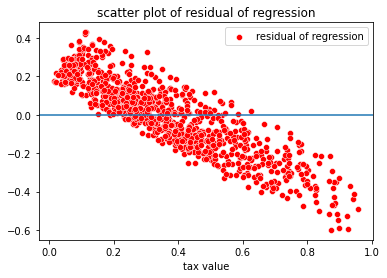

SSE (sum of squared errors) =  35.817977559266666
ESS (explained sum of squares) =  9.414783070579343
TSS (Total sum of squares) =  45.23276062984601
MSE (mean squared error) =  0.03581797755926667
RMSE (root mean squared error) =  0.1892563804981662
Percent of variance in tax value explained by area =  20.8 %
SSE (sum of squared errors) =  35.817977559266666
ESS (explained sum of squares) =  9.414783070579343
TSS (Total sum of squares) =  45.23276062984601
MSE (mean squared error) =  0.03581797755926667
RMSE (root mean squared error) =  0.1892563804981662
Percent of variance in tax value explained by area =  20.8 %
SSE baseline =  45.23276062984599
MSE baseline =  0.04523276062984599
RMSE baseline =  0.21267994881945498
model performed better than baseline on SSE
model performed better than baseline on MSE
model performed better than baseline on RMSE


In [16]:
evaluate.baseline_mean_errors(train_scaled[pred_col])
evaluate.plot_residuals(train_scaled[pred_col],train_scaled.yhat)
evaluate.regression_errors(train_scaled[pred_col],train_scaled.yhat)
evaluate.better_than_baseline(train_scaled[pred_col], train_scaled["yhat"])

In [17]:
SSE2 = mean_squared_error(train_scaled[pred_col],train_scaled["yhat"])*len(train_scaled)
SSE2_baseline = mean_squared_error(train_scaled[pred_col],train_scaled["yhat_baseline"])*len(train_scaled)
SSE2,SSE2_baseline

## SSE sum of squares is taking the variation between the yhat/yhatbaseline and each point (residual), squaring the distance of each and summing them.
## TSS total sum of squares is the sum of the difference between the actual data and the mean of that data

(35.817977559266666, 45.232760629846)